## Plot Variant Counts of Subjects by Gene

In [2]:
library("tidyverse")
library("ggthemes")
library("stringr")
library("ggrepel")

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [6]:
msclsk_df <- read_tsv("./data/tissueSpecific/MSCLSK.isoform_specific.tsv")
base_subj_cols <- colnames(msclsk_df)[grepl("GTEX", colnames(msclsk_df))]

Rows: 155533 Columns: 716
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (712): CHR, VARIANT_ID, GENE_ID, TISSUE_ID, VARIANT_ANNOTATION, GTEX-13P...
dbl   (4): POS, transcript_count, max_transcripts_exon, max_transcripts_gene

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [6]:
# For least # of NAs in a variant
na_row <- msclsk_df %>% select(all_of(base_subj_cols)) %>% is.na() %>% rowSums()
d_i <- grep(min(na_row), na_row)

d_row <- msclsk_df[d_i,]
gene_id <- d_row["GENE_ID"][1]
subj_cols <- colnames(d_row)[grepl("GTEX", colnames(d_row))]
d_row <- d_row %>% select(all_of(subj_cols))
d_row <- drop_na(data.frame("RATIO"=t(d_row)))

In [9]:
# Every variant in every individual
vec_1d <- as.vector(as.matrix(msclsk_df %>% select(all_of(base_subj_cols))))
d_row <- data.frame("RATIO"=na.omit(vec_1d))

In [7]:
# For an individual (with fewest NAs)
subj_df <- msclsk_df %>% select(all_of(base_subj_cols))

na_col <- colSums(is.na(msclsk_df %>% select(all_of(base_subj_cols))))
d_i <- grep(min(na_col), na_col)
d_row <- drop_na(subj_df[,d_i])
subj_name <- colnames(d_row)
colnames(d_row) <- c("RATIO")

In [8]:
# Split and convert to integer
d_row <- d_row %>% separate(RATIO, sep="\\|", into=c("REF", "ALT"))
d_row <- data.frame(lapply(d_row, as.integer))

# Binomial test
d_row$p_val <- apply(d_row[,c("REF","ALT")], 1, function(x) binom.test(x[1],x[1]+x[2],p=0.5)$p.value)
d_row$q_val <- p.adjust(d_row$p_val, method = "fdr")
d_row <- d_row %>% mutate(sig=q_val < 0.05)

Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”


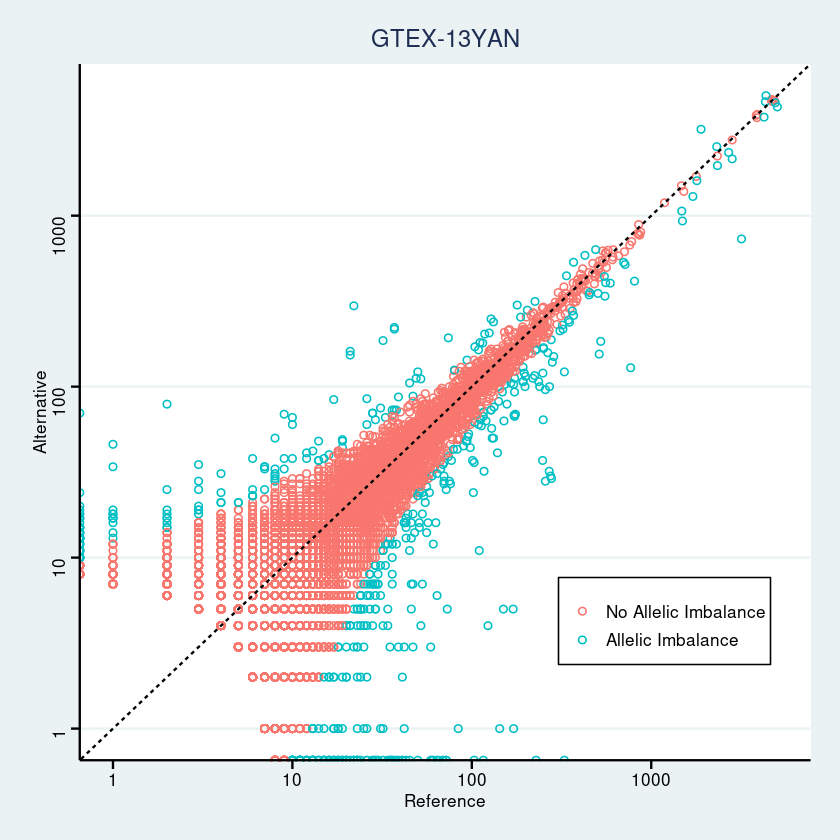

In [28]:
d_row %>% ggplot(aes(x=REF, y=ALT)) + geom_point(aes(col=sig), shape=1) + geom_abline(linetype="dashed") + 
  scale_x_continuous(trans="log10") + scale_y_continuous(trans="log10") + 
  labs(title=subj_name, x="Reference", y="Alternative") + 
  theme_stata() + theme(legend.position = c(0.8, 0.2), legend.title=element_blank()) + 
  scale_color_hue(labels = c("No Allelic Imbalance", "Allelic Imbalance"))

In [ ]:
gene_sub <- msclsk_df %>% filter(GENE_ID == example_gene)
subj_cols <- colnames(gene_sub)[grepl("GTEX", colnames(gene_sub))]
gene_sub <- gene_sub %>% select(all_of(subj_cols))
# gene_sub[c('REF', 'ALT')] <- str_split_fixed(gene_sub$Name, ' ', 2)

In [34]:
gene_sub <- msclsk_df %>% filter(GENE_ID == example_gene)
subj_cols <- colnames(gene_sub)[grepl("GTEX", colnames(gene_sub))]
gene_sub <- gene_sub %>% select(all_of(subj_cols))
# gene_sub[c('REF', 'ALT')] <- str_split_fixed(gene_sub$Name, ' ', 2)

## Boxplots of Counts in Genes by Tissue

In [2]:
library(tidyverse)
library(ggthemes)

df <- read_csv("./data/VariantCtByTissue.csv")

sample_sizes <- read_csv("./data/tissue_sample_sizes.csv")

df <- merge(df, sample_sizes)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Rows: 1150176 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): GENE_ID, TISSUE_ID
dbl (1): n_vars

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 54 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): TISSUE_ID
dbl (1): n_samples

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet

Warning message:
“Removed 346133 rows containing non-finite values (stat_boxplot).”


NULL

Warning message:
“Removed 346133 rows containing non-finite values (stat_boxplot).”


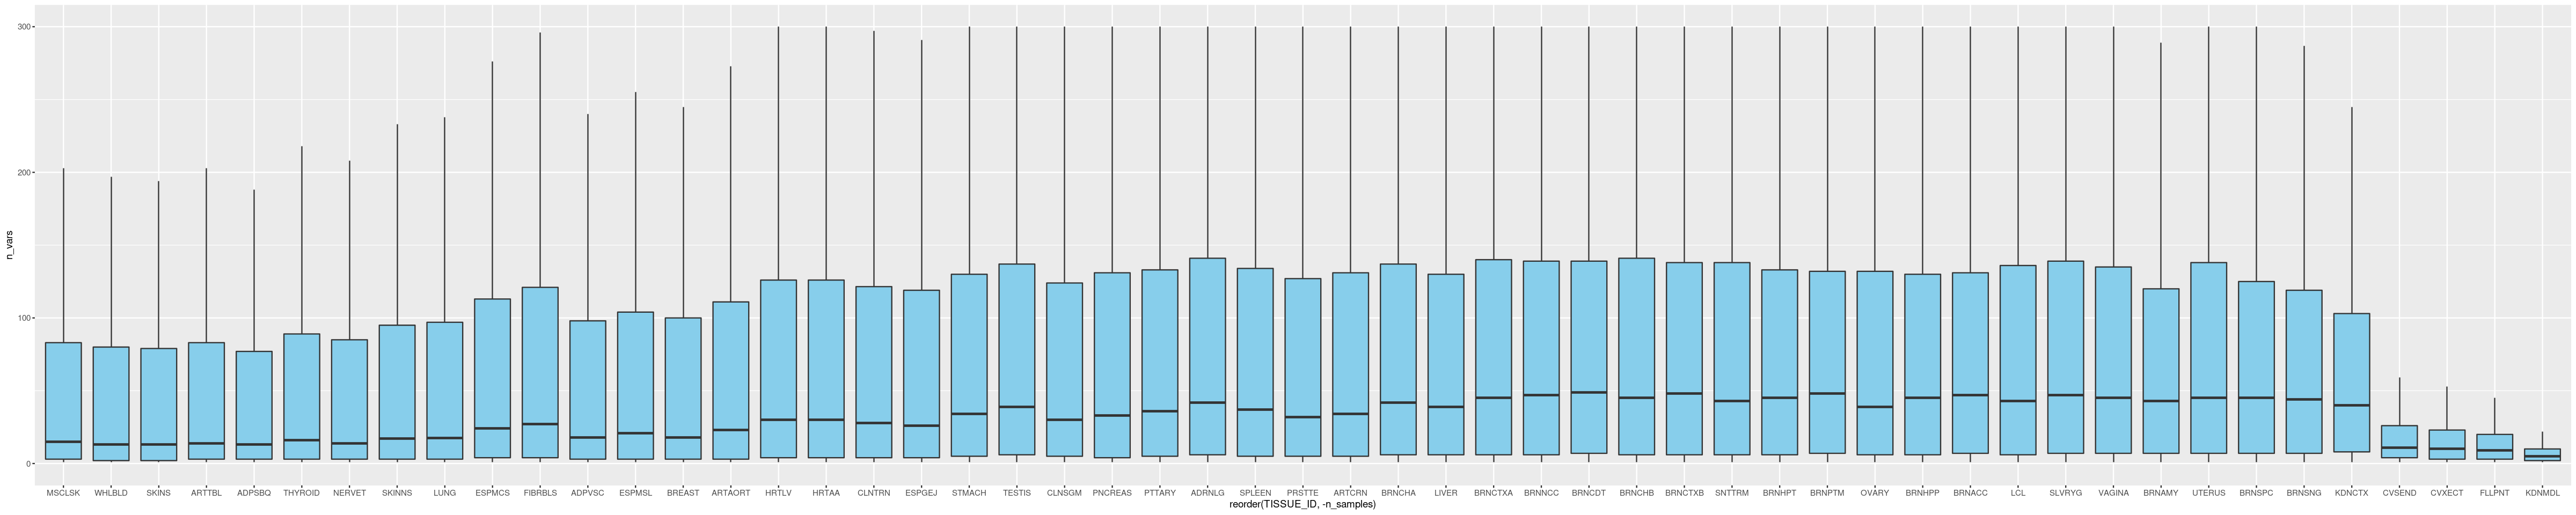

In [3]:
options(repr.plot.width=40, repr.plot.height=8)

df %>% ggplot(aes(x=reorder(TISSUE_ID, -n_samples), y=n_vars)) + 
    geom_boxplot(fill="skyblue", outlier.shape=NA) + 
    ylim(0, 300)
    labs(x="Tissue", y="Variant Counts", title="Variants per Gene by Tissue") + theme_stata()

ggsave("VariantbyGene.png", width=40, height=8)

In [ ]:
df %>% group_by(TISSUE_ID) %>% select(n_vars)

In [7]:
cor(df$n_vars, df$n_samples)

[1] 0.2580422

In [14]:
df %>% filter(TISSUE_ID == "MSCLSK") %>% pull(n_vars) %>% mean

[1] 587.7516

In [15]:
df %>% filter(TISSUE_ID == "ADRNLG") %>% pull(n_vars) %>% mean

[1] 288.546

In [4]:
df <- read_csv("./data/ShareSRLRASE_FETest/GTEX-13QJ3_MSCLSK.csv")

df <- df %>% mutate(PVALUE=p.adjust(PVALUE, "BH"))

df <- df %>% mutate(LAB=rank(PVALUE))

df <- df %>% arrange(PVALUE) %>% filter(PVALUE != 0)

Rows: 86 Columns: 8
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): TRANSCRIPT_ID
dbl (7): REF_COUNT_SR, ALT_COUNT_SR, RATIO_SR, REF_COUNT_LR, ALT_COUNT_LR, R...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [10]:
df

TRANSCRIPT_ID,REF_COUNT_SR,ALT_COUNT_SR,RATIO_SR,REF_COUNT_LR,ALT_COUNT_LR,RATIO_LR,PVALUE,LAB
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENST00000221476,5307.00000,4428.00000,0.5451464,3244.00000,3111.00000,0.5104642,0.001477685,1.0
ENST00000369085,483.00000,514.50000,0.4842105,155.00000,95.50000,0.6187625,0.005590841,2.0
ENST00000602725,154.00000,191.00000,0.4463768,11.00000,34.00000,0.2444444,0.292739241,3.0
ENST00000263856,96.00000,98.00000,0.4948454,29.00000,14.00000,0.6744186,0.353549266,7.5
ENST00000292614,207.00000,181.00000,0.5335052,359.00000,416.00000,0.4632258,0.353549266,7.5
ENST00000298295,347.00000,333.00000,0.5102941,60.00000,89.00000,0.4026846,0.353549266,7.5
ENST00000300648,78.50000,72.50000,0.5198675,21.00000,37.00000,0.3620690,0.353549266,7.5
ENST00000322028,165.00000,107.00000,0.6066176,516.00000,456.00000,0.5308642,0.353549266,7.5
ENST00000334660,97.00000,89.00000,0.5215054,50.00000,25.00000,0.6666667,0.353549266,7.5


Saving 6.67 x 6.67 in image



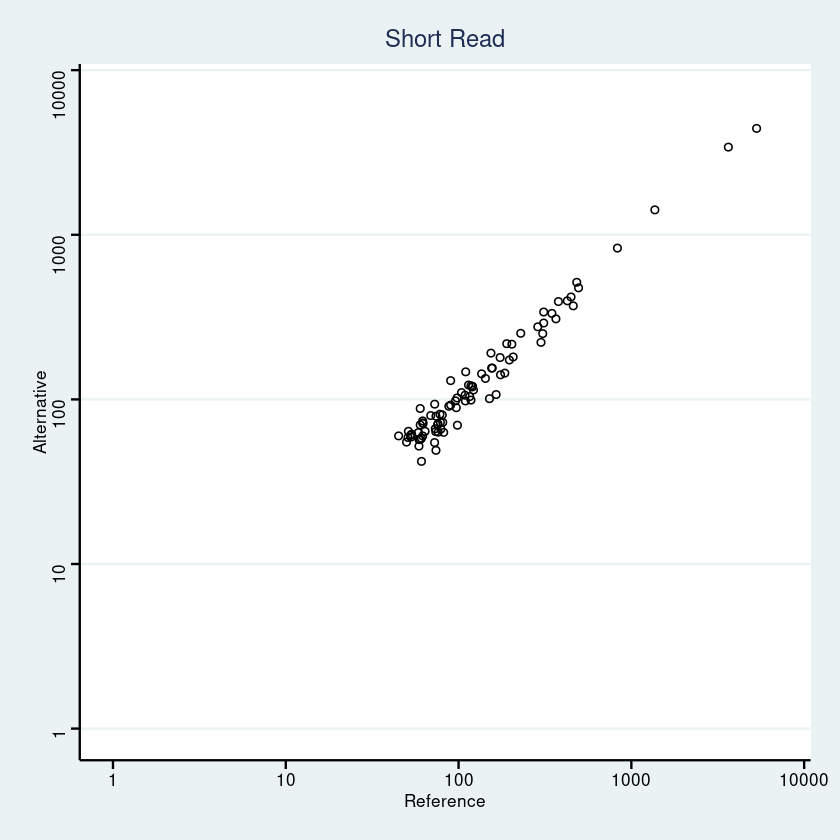

In [8]:
df %>% ggplot(aes(x=REF_COUNT_SR, y=ALT_COUNT_SR)) + geom_point(shape=1) + #geom_abline(linetype="dashed") + 
  scale_x_continuous(trans="log10", limits=c(1, 7000)) + scale_y_continuous(trans="log10", limits=c(1, 7000)) + 
  labs(title="Short Read", x="Reference", y="Alternative") + 
  theme_stata() + theme(legend.position = c(0.8, 0.2), legend.title=element_blank()) +
  # geom_text_repel(aes(label = LAB), alpha=0.5, size=3, max.overlaps=500) + 
  scale_color_hue(labels = c("P >= 0.05", "P < 0.05"))

ggsave("short_read_sample.jpg", dpi=500)

Saving 6.67 x 6.67 in image



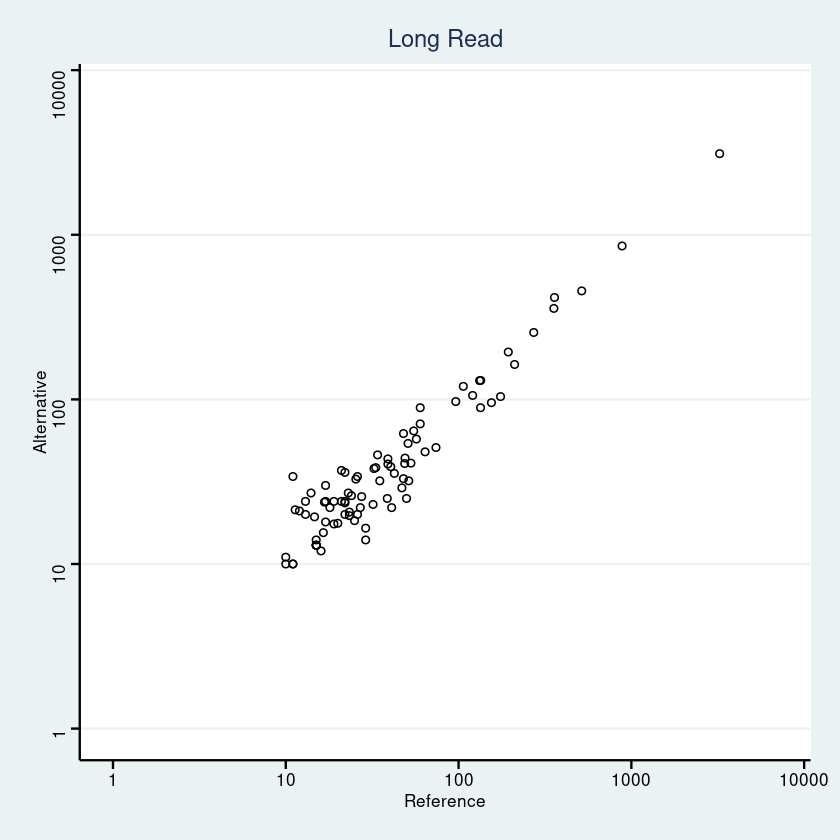

In [9]:
df %>% ggplot(aes(x=REF_COUNT_LR, y=ALT_COUNT_LR)) + geom_point(shape=1) + #geom_abline(linetype="dashed") + 
  scale_x_continuous(trans="log10", limits=c(1, 7000)) + scale_y_continuous(trans="log10", limits=c(1, 7000)) + 
  labs(title="Long Read", x="Reference", y="Alternative") + 
  theme_stata() +
  # geom_text_repel(aes(label = LAB), alpha=0.5, size=3, max.overlaps=500) + 
  scale_color_hue(labels = c("P >= 0.01", "P < 0.01"))

ggsave("long_read_sample.jpg", dpi=500)